# Lecture 8 - Missing Data

## Today's Learning Goals

By the end of this lecture, you should be able to:

- Identify and explain the three common types of missing data mechanisms.
- Identify a potential consequence of removing missing data on downstream analyses.
- Identify a potential consequence of a mean imputation method on downstream analyses.
- Identify the four steps involved with a multiple imputation method for handling missing data.
- Use the `mice` package in `R` to fit multiple imputed models.

## Loading Libraries

In [1]:
options(repr.matrix.max.rows = 20)
library(tidyverse)
library(nycflights13)
library(mice)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘mice’




The following object is masked from ‘package:stats’:

    filter




The following objects are masked from ‘package:base’:

    cbind, rbind




## 1. Types of Missing Data

In Statistics, there are three types of missing data:

- **Missing completely at random (MCAR)**.
- **Missing at random (MAR)**.
- **Missing not at random (MNAR)**.

It is in our best interest to identify the type of missing data we have. Proper identification will determine the class of approach we will take to deal with missingness in any statistical analysis.

### 1.1. Missing Completely At Random (MCAR)

In this type, missing data appear **totally by chance**. Hence, missingness is independent of the data. Roughly speaking, all our observations (**rows in the dataset**) have the same chance of containing missing data (i.e., an `NA` in one of the columns).

```{important}
It is the ideal class of missing data since **there is no missingness pattern**.
```

**Example**

We are trying to count the number of car accidents in Vancouver. To do that, we are monitoring the traffic in 100 strategic points of the city with cameras. Say that we count how many vehicles passed by each one of those cameras for every minute of the day. We have 101 **variables**: `time`, `Camera_1`, ..., `Camera_100`. 

Suppose that **any camera** has a $1\%$ **chance** of failing for **any given minute**. If a camera fails, you get MCAR data for that minute.

### 1.2. Missing At Random (MAR)

In this type, **missingness depends on the observed data we have**. Therefore, we could use some imputation techniques for this missingness, such as **multiple imputation** (to be covered later on today), based on the rest of our available data (a **hot deck** imputation technique).

```{important}
Missing data imputation techniques are divided into two classes:

- **Hot deck:** Those incomplete rows in our current dataset are imputed using the information provided by the complete rows **within the same dataset**.
- **Cold deck:** Those incomplete rows in our current dataset are imputed using the information provided by the complete rows of another dataset **with the same column structure**.

**The scope of this lecture pertains to hot deck techniques.**
```

**Example**

Following up with the previous example, an external device is attached to the cameras to increase the image quality at low light situations (night time) **and we have the recording time in our dataset**. The external device is activated **from 6 p.m. to 5 a.m.** However, the device has a $10\%$ **chance** of not working in a given minute. The chances are not the same for all the observations but depend on the data we observed, more specifically, **night** `time`. 

### 1.3. Missing Not At Random (MNAR)

This is the most serious type of missingness since the MNAR data **depends on unobservable quantities**.

**Example**

With the previous example, **if we did not record time**, we would be MNAR data since we do not have any other information rather than just the car count. Another missingness cause of this type would be that, as the cameras get older, their probability of failure increases, **but we cannot check this from our observed data**.

## 2. Handling Missing Data

We will explore different techniques to impute missing data **based on the type of missingness**.

### 2.1. Listwise Deletion

It is the simplest way to deal with missing data.

**Is there any missing data in your row?** If yes, we just remove the row.

If the data is MCAR, **we are not introducing bias by removing the rows**. We can still get unbiased estimators for whichever our analysis is, such as **regression coefficients**.

We can also estimate the **standard errors** correctly, but they will be higher than they could be since we discard incomplete observations.

```{exercise}
:label: lecture8-q1

Are these higher standard errors related to the MCAR nature of the deleted rows?

**A.** Yes.

**B.** No.
```

```{solution} lecture8-q1
:label: lecture8-ans1

No. These higher standard errors are not due to the MCAR nature of our rows per se. Instead, these standard errors are larger because we have fewer data points to estimate our modelling parameters (recall the frequentist paradigm!).
```

Let us start with our lecture's toy dataset: the `flights` dataset from the package `nycflights13`. It contains the **on-time data** of 336,776 flights that departed New York City in 2013. 

We will use the following columns:

- `dep_delay`: departure delays in minutes.
- `arr_delay`: arrival delays in minutes.
- `carrier`: two-letter carrier abbreviation.

We will try getting the mean `dep_delay` per `carrier,` but we have missing data in `dep_delay`, which will return a summary with `NA`s.

In [2]:
flights |> 
  group_by(carrier) |> 
  summarise(dep_delay = mean(dep_delay)) |>
  mutate_if(is.numeric, round, 3)

carrier,dep_delay
<chr>,<dbl>
9E,NA
AA,NA
AS,NA
B6,NA
DL,NA
EV,NA
F9,NA
FL,NA
HA,4.901


**Assuming data is MCAR**, if we want to make a listwise deletion to get the means by `carrier`, we just use `na.rm = TRUE` in `mean()`.

In [3]:
flights |> 
  group_by(carrier) |> 
  summarise(dep_delay = mean(dep_delay, na.rm = TRUE)) |>
  mutate_if(is.numeric, round, 2)

carrier,dep_delay
<chr>,<dbl>
9E,16.73
AA,8.59
AS,5.80
B6,13.02
DL,9.26
EV,19.96
F9,20.22
FL,18.73
HA,4.90


Nonetheless, we have to be careful. **If the missing data in `flights` is not MCAR**, we can introduce serious bias in our estimates (means in this case) for some given statistical approach.

```{admonition} But, why a bias?
Let us set another example to explain the bias issue when data missingness is present. Suppose that people with low income have a higher chance of omitting their income (as a **numeric variable**) in a given survey used for Regression Analysis. Then, **if we just drop those rows**, we are skewing our analysis towards people with higher income without knowing. So, there will be a bias in our regression estimates.
```

```{exercise}
:label: lecture8-q2

Let us retake the previous survey example regarding low-income respondents. Suppose this survey collects additional information, such as the respondent's specific neighbourhood, which is a complete column. Then, you could match this extra information with some other neighbourhood databases identifying low, middle, and high-income areas.

What class of missing data are these *missing numeric incomes* in the survey?

**A.** MCAR.

**B.** MAR.

**C.** MNAR.
```

```{solution} lecture8-q2
:label: lecture8-ans2

It is **MAR** since the **missingness depends on the observed data we have**, which is the collected neighbourhood. 

If we had not collected this extra information, we would not have been able to match our survey with these neighbourhood databases, making the MNAR case! 
```

### 2.2. Mean Imputation

The title is very suggestive. Let us just use **the mean of our variable of interest to impute the missing data**.

```{caution}
This imputation technique can only be used with continuous and count-type variables!
```

Re-taking the `flights` dataset, **for the exercise's sake** (not to be generalized to other data cases), we will filter those observations with `NA`s in `arr_delay` **OR** `dep_delay` values larger than 100 minutes. Then, we will only sample 1000 flights.

In [4]:
options(repr.plot.height = 7, repr.plot.width = 12)

set.seed(123)
sampled_flights <- flights |>
  select(dep_delay, arr_delay) |>
  filter(is.na(arr_delay) | dep_delay > 100) |>
  sample_n(size = 1000)

scatterplot_flights <- sampled_flights |>
  ggplot(aes(dep_delay, arr_delay)) +
  geom_point(size = 2) +
  ggtitle("Observed Data (Without NAs)") +
  geom_smooth(method = "lm", formula = y ~ x, se = FALSE, linewidth = 2) +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18)
  ) +
  scale_x_continuous(breaks = seq(0, 500, 100)) +
  xlab("Departure Delay (min)") +
  ylab("Arrival Delay (min)")

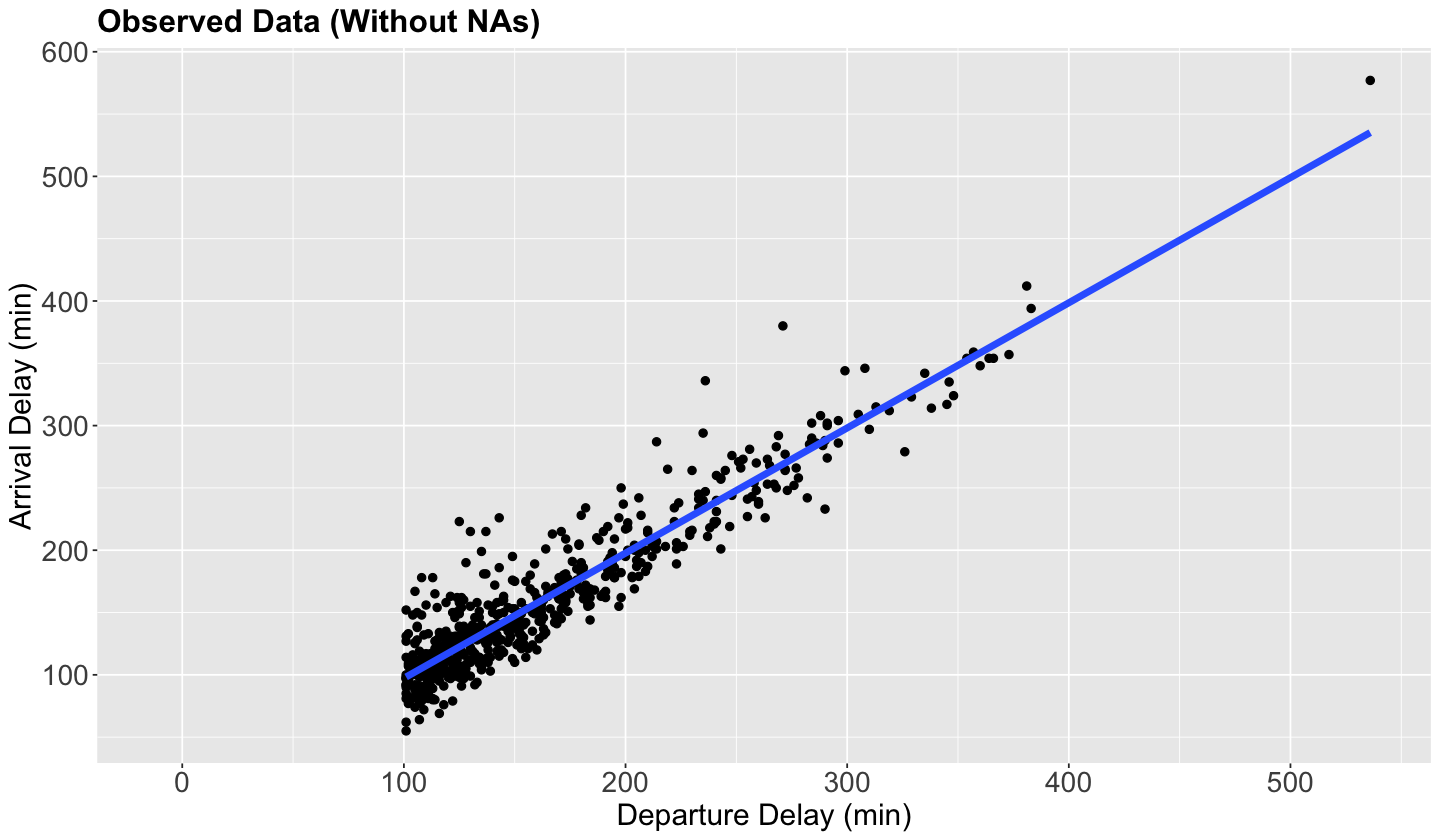

In [5]:
suppressWarnings(suppressMessages(print(scatterplot_flights)))

```{attention}
Note the condition `dep_delay > 100` is also depicted in the plot.
```

The blue line is just the estimated Ordinary Least-squares (OLS) linear regression of `dep_delay` versus `arr_delay` **with 593 complete observations**. Nonetheless, since the conditional is `is.na(arr_delay) | dep_delay > 100` (i.e., **OR**), **we would eventually have an imputed subset of observations with negative `dep_delay`**, i.e., flights on time but missing `arr_delay`. We can see some rows under this situation in the below data frame.

This missigness pattern will provide a **particular behaviour in our subsequent mean imputations**.

In [6]:
sampled_flights |> filter(is.na(arr_delay) & !is.na(dep_delay))

dep_delay,arr_delay
<dbl>,<dbl>
2,NA
1,NA
43,NA
-4,NA
8,NA
7,NA
31,NA
-11,NA
12,NA


Moving along, it is necessary to perform an **exploratory data analysis (EDA)** on our data missingness. We can use the function `md.pattern()` from the package `mice` to display missing data patterns.

,dep_delay,arr_delay,
593,1,1,0
53,1,0,1
354,0,0,2
,354,407,761


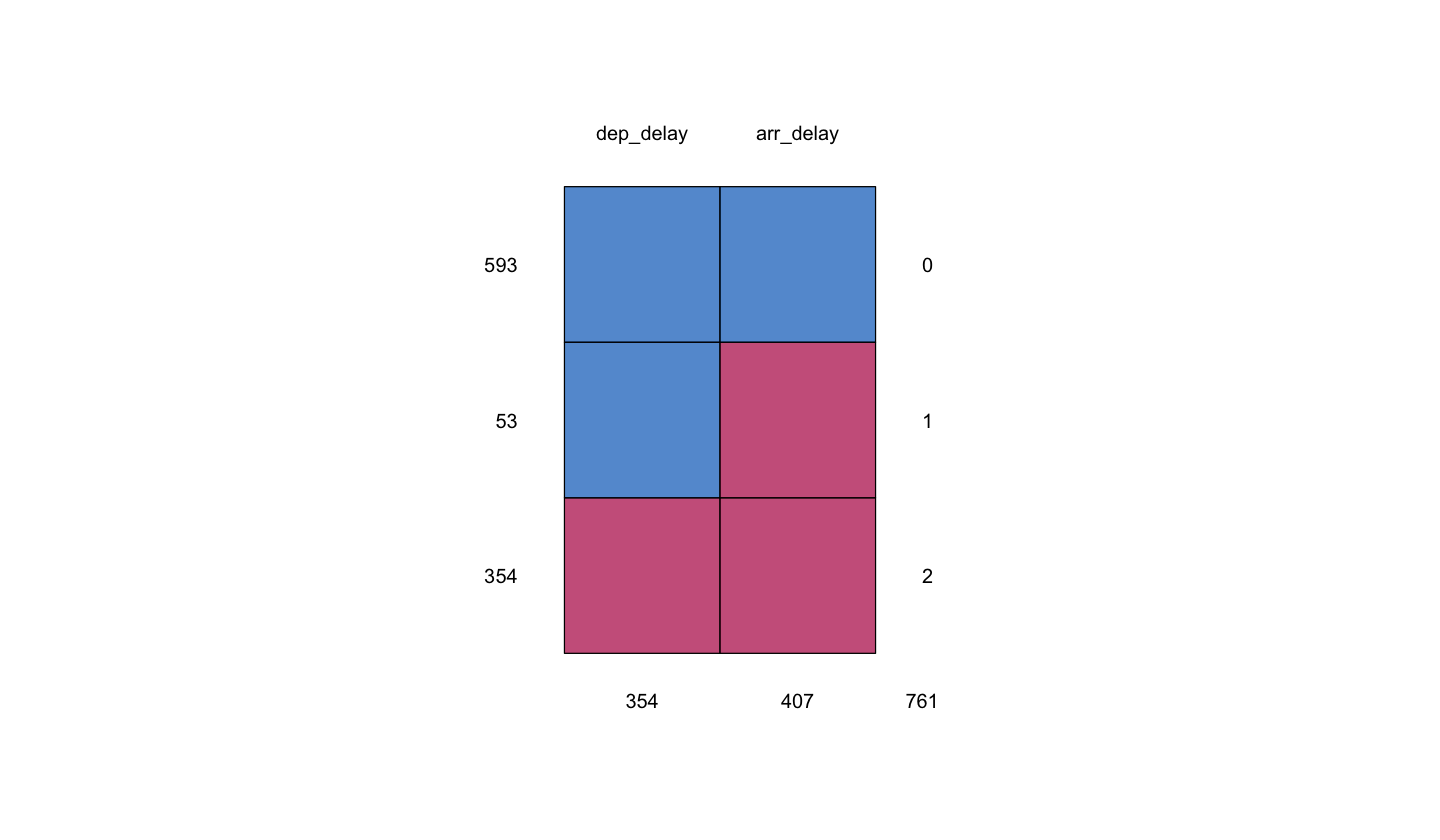

In [7]:
md.pattern(sampled_flights)

We can interpret the $4 \times 3$ matrix (and diagram) above in the following way:

```{important}
- For the $4 \times 3$ table, in the columns `dep_delay` and `arr_delay` (rows 1 to 3):
    - `0` indicates that neither of the variables is missing.
    - `1` indicates that one variable is present.
    - `2` indicates that two variables are missing. 
    - Row numbers indicate those observations with the variables present/missing:
        - `593` indicates the number of rows where `dep_delay` and `arr_delay` are **jointly** present.
        - `53` indicates the number of rows where `dep_delay` is present and `arr_delay` is missing.
        - `354` indicates the number of rows where `dep_delay` and `arr_delay` are **jointly** missing.
        - Then, we have $593 + 53 + 354 = 1000$ rows in total (our sample size!).
    - Column numbers indicate those observations with the **standalone** missing variables:
        - `354` indicates the number of rows where `dep_delay` is missing, **regardless** of whether `arr_delay` is missing or not.
        - `407` indicates the number of rows where `arr_delay` is missing, **regardless** of whether `dep_delay` is missing or not.       
- For the columns in the diagram `dep_delay` and `arr_delay`, the coloured cells indicate:
    - Blue indicates that the variable is present.
    - Red indicates that the variable is missing.
```

Therefore, we have 593 observations with non-missing data in both `dep_delay` and `arr_delay`, 53 with `arr_delay` missing, and 354 with both `dep_delay` and `arr_delay` missing. 

The `md.pattern()` summary shows that our sample **does NOT contain** observations where `dep_delay` is missing and `arr_delay` is present.

Now, we will impute the overall means of `dep_delay` and `arr_delay`.

In [8]:
# Manually imputing the missing data.
sampled_flights_imputed <- sampled_flights |>
  mutate(flag = as_factor(if_else(is.na(dep_delay) | is.na(arr_delay), "missing", "observed"))) |>
  mutate(dep_delay = if_else(is.na(dep_delay), mean(dep_delay, na.rm = TRUE), dep_delay)) |>
  mutate(arr_delay = if_else(is.na(arr_delay), mean(arr_delay, na.rm = TRUE), arr_delay))

# Now, using mice() from the mice package.
sampled_flights_imputed_mice <- mice(sampled_flights, m = 1, method = "mean", maxit = 1)


 iter imp variable
  1   1  dep_delay  arr_delay


In [9]:
head(sampled_flights) # Checking first rows in our original sample.

dep_delay,arr_delay
<dbl>,<dbl>
NA,NA
178,185
109,107
2,NA
NA,NA
198,182


In [10]:
head(sampled_flights_imputed_mice$where) # Checking logical flags for missing data in mice() object.

,dep_delay,arr_delay
1,TRUE,TRUE
2,FALSE,FALSE
3,FALSE,FALSE
4,FALSE,TRUE
5,TRUE,TRUE
6,FALSE,FALSE


In [11]:
flag <- pmin(rowSums(sampled_flights_imputed_mice$where), 1) # Flag for imputed data.
flag <- if_else(flag == 0, "observed", "missing") # Flag for imputed data.
sampled_flights_imputed_mice <- mice::complete(sampled_flights_imputed_mice) |> mutate(flag = flag)

In [12]:
# Sanity check of amount of imputed values.
table(sampled_flights_imputed$flag)


 missing observed 
     407      593 

In [13]:
table(sampled_flights_imputed_mice$flag)


 missing observed 
     407      593 

We will now plot the imputed values as purple points, and another estimated OLS linear regression in red with the $n = 1000$ sampled observations (non-imputed **AND** imputed). 

Note the horizontal pattern in the imputed purple points, which is the subset of observations with the **particular behaviour we previously mentioned**.

In [14]:
## Plotting imputed versus observed.
scatterplot_flights <- sampled_flights_imputed_mice |> 
  ggplot() + 
  geom_point(aes(dep_delay, arr_delay, color = flag), size = 2) + 
  geom_smooth(aes(dep_delay, arr_delay), linewidth = 2, formula = y ~ x, color = "red", method ='lm', se = FALSE) +
  geom_smooth(aes(dep_delay, arr_delay), linewidth = 2, formula = y ~ x, method = "lm", data = sampled_flights, se = FALSE) + 
  scale_color_manual(values = c("purple", "black")) + 
  ggtitle("Imputed Fit (red) versus Observed Fit (blue)") +
theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18),
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 17, face = "bold")
  ) +
  scale_x_continuous(breaks = seq(0, 500, 100)) +
  xlab("Departure Delay (min)") +
  ylab("Arrival Delay (min)")

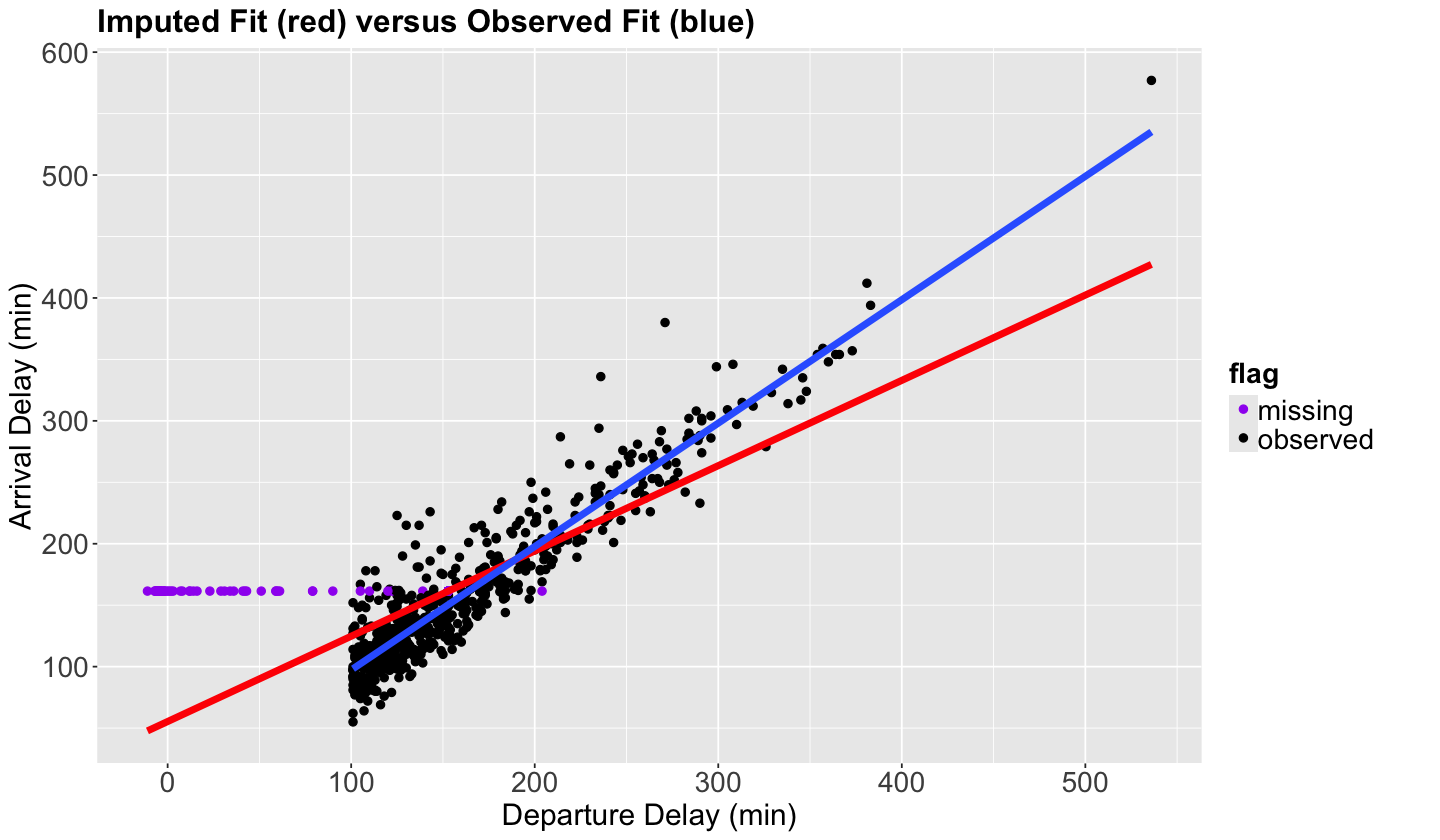

In [15]:
suppressWarnings(suppressMessages(print(scatterplot_flights)))

Also, notice that by imputing the mean, **we are artificially reducing the standard deviation of our data** which is a drawback of mean imputation.

In [16]:
# Standard deviation of the complete observed data.
sampled_flights |> 
  na.omit() |> 
  summarise_all(.funs = sd) |>
  mutate_if(is.numeric, round, 2)

dep_delay,arr_delay
<dbl>,<dbl>
61.05,65.45


In [17]:
# Standard deviation of all the data (imputed and non-imputed).
sampled_flights_imputed |> 
  select(-flag) |> 
  summarise_all(.funs = sd) |>
  mutate_if(is.numeric, round, 2)

dep_delay,arr_delay
<dbl>,<dbl>
56.54,50.38


```{important}
This behaviour on the sample standard deviation is explained given its mathematical computation:

$$s = \sqrt{\sum_{i = 1}^n \frac{(x_i - \bar{x})^2}{n - 1}}.$$

Note that this $s$ will be quite sensitive when imputing values with the corresponding mean $\bar{x}$.
```

Having said all this, let us proceed to a more "robust" imputation method.

### 2.3. Regression Imputation

From the black points (**complete observations**) in the previous plot, we can notice **a clear positive relation between `arr_delay` changes with `dep_delay`**. Hence, why not using the estimated OLS linear regression in blue (**fitted with those complete 593 observations**) to estimate those missing values?

We can do it automatically via `mice()` using `method = "norm.predict"`.

In [18]:
sampled_flights_imputed_reg <- mice(sampled_flights, method = "norm.predict", seed = 1, m = 1, print = FALSE)
flag <- pmin(rowSums(sampled_flights_imputed_reg$where), 1) # Flag for imputed data.
flag <- if_else(flag == 0, "observed", "missing") # Flag for imputed data.
sampled_flights_imputed_reg <- complete(sampled_flights_imputed_reg) |> 
  mutate(flag = flag)

# Sanity check of amount of imputed values.
table(sampled_flights_imputed_reg$flag)


 missing observed 
     407      593 

Then, we plot our dataset (including those imputted data points using OLS).

In [19]:
## Plotting imputed versus observed.
scatterplot_flights_reg <- sampled_flights_imputed_reg |> 
  ggplot() + 
  geom_point(aes(dep_delay, arr_delay, color = flag), size = 2) + 
  geom_smooth(aes(dep_delay, arr_delay), linewidth = 2, formula = y ~ x, color = "red", method='lm', se = FALSE) +
  geom_smooth(aes(dep_delay, arr_delay), linewidth = 2, formula = y ~ x, method = "lm", data = sampled_flights, se = FALSE) + 
  scale_color_manual(values = c("purple", "black")) + 
  ggtitle("Imputed Fit (red) versus Observed Fit (blue)") +
theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18),
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 17, face = "bold")
  ) +
  scale_x_continuous(breaks = seq(0, 500, 100)) +
  xlab("Departure Delay (min)") +
  ylab("Arrival Delay (min)")

Now, all the purple points (imputed values) are on the imputed fit (red) line, **which is now just an extension of the observed fit (blue) line**.

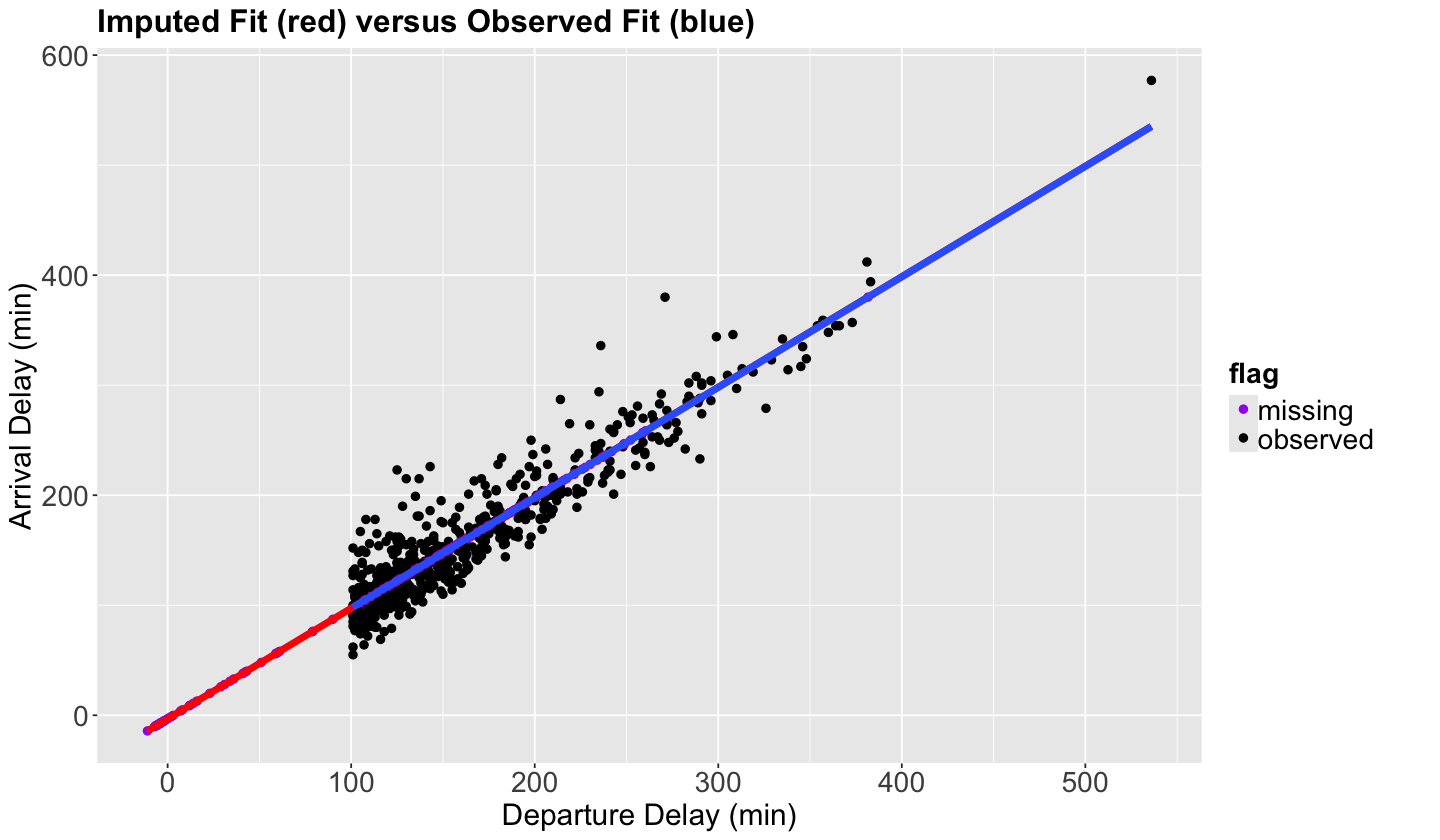

In [20]:
suppressWarnings(suppressMessages(print(scatterplot_flights_reg)))

Since the method imputes all the points perfectly in the regression line, **we will reinforce the data's relationships**. For example, let us calculate the correlation of the imputed data vs the observed data.

In [21]:
# Only complete observations.
as_tibble(cor(sampled_flights, use = "complete.obs")) |>
  mutate_if(is.numeric, round, 2)

dep_delay,arr_delay
<dbl>,<dbl>
1.00,0.94
0.94,1.00


In [22]:
# All observations (complete and imputed).
as_tibble(cor(sampled_flights_imputed_reg |> select(-flag))) |>
  mutate_if(is.numeric, round, 2)

dep_delay,arr_delay
<dbl>,<dbl>
1.00,0.96
0.96,1.00


```{attention}
Regression imputation seems to have a more "inline" behaviour for imputed data than just using the mean since we are basically using regression-fitted values for this missing data. Moreover, **we can extend this framework to more than two variables simultaneously**.

Nevertheless, we still fix our imputation on a single set of estimated regression parameters. In fact, we could have a more clever strategy that would rely on different simulated datasets **given what prior COMPLETE information we have in our dataset**.
```

### 2.4. Last Observation Carried Over

Another method that we might see out there is imputing data by repeating the previous observation. This is more frequent when dealing with temporal data, **and will be out of the scope of this course**.

### 2.5. Multiple Imputation

Having explored mean and regression imputations, let us proceed to a simulation-based method called **multiple imputation**.

We have seen that using a single value for the imputation causes problems, such as reducing our dataset variance. Then, a handy approach is the multiple imputation method. 

The idea here is, instead of imputing one value for missing data, we impute multiple values. **But how can we do it?**

We can do it via the `mice()` function, which offers this multiple imputation method. **MICE** stands for **Multiple Imputation by Chained Equations**.

Roughly speaking, for a data frame `data`, the four **automatic steps** in this `R` function are the following:

1. Create `m` copies of this dataset: `data_1`, `data_2`,..., `data_m`.
2. In each copy, impute the missing data with different values (the observed values will remain the same).
3. Carry out the analysis for each dataset separately. For example, **fit an OLS linear regression model for each one of the datasets `data_1`, `data_2`,...,`data_m` when you have a continuous variable to impute**.
4. Combine the separate models into one final **pooled model**.

We would use our **pooled model**, fitted with our response of interest subject to our regressor set, to answer our inferential or predictive inquiries. The below diagram provides a clearer perspective

```{figure} ../img/mult-imp-workflow.png
:height: 400px
:name: mult-imp

Source: [van Buuren (2012)](https://stefvanbuuren.name/fimd/workflow.html).
```

```{important}
Note that the suitable regression model will be chosen accordingly depending on the nature of our variable of interest to impute. Therefore, `mice()` will use the following regression models:

- Binary Logistic regression for binary variables.
- Multinomial Logistic regression for categorical and nominal variables.
- Ordinal Logistic regression for categorical and ordinal variables.

**We have to make sure to set up the correct variable type before imputing!**
```

**Now, how do we impute the missing data in step 2?**

By default, `mice()` implements the **predictive mean matching (PMM) found in [Rubin (1987)](https://gw2jh3xr2c.search.serialssolutions.com/log?L=GW2JH3XR2C&D=ZEEST&J=TC0000340639&P=Link&PT=EZProxy&H=6c88ebd0c3&U=https%3A%2F%2Fezproxy.library.ubc.ca%2Flogin%3Furl%3Dhttps%3A%2F%2Fonlinelibrary.wiley.com%2Fdoi%2Fbook%2F10.1002%2F9780470316696) on page 166**.
This is a univariate Bayesian method that does the following **for each column**:

1. Estimate the OLS linear regression coefficient $\hat{\beta}_1$ and $\hat{\sigma}$ of the column where the missing values to impute are located (as the response) versus the other column (as the regressor), **using the observed complete rows only**.
2. Draw $\hat{\beta}_1^*$ and $\hat{\sigma}^*$ using a proper posterior distribution.
3. Compute the fitted values for the column used as response in step (1), either using $\hat{\beta}_1$ and $\hat{\sigma}$ for those non-missing cases (i.e., $\hat{y}_i$) or $\hat{\beta}_1^*$ and $\hat{\sigma}^*$ (i.e., $\hat{y}_i^*$) for those missing cases.
4. For each fitted value $\hat{y}_i^*$, we find a given number of donors (5 by default in `mice()`) from all the $\hat{y}_i$s which are the closest ones to $\hat{y}_i^*$.
5. We randomly select one of these donors to impute the corresponding missing value.
6. The process is repeated `m` times.

```{important}
Note that this algorithm also has a multivariate version in matrix notation. 
```

Let us implement this univariate process with `sampled_flights` with `m = 20`.

In [23]:
set.seed(123) # We are running a simulation, this we need to set a seed.
sampled_flights_imputed_PMM <- mice(sampled_flights, m = 20, printFlag = FALSE)
sampled_flights_imputed_PMM

Class: mids
Number of multiple imputations:  20 
Imputation methods:
dep_delay arr_delay 
    "pmm"     "pmm" 
PredictorMatrix:
          dep_delay arr_delay
dep_delay         0         1
arr_delay         1         0

We can check the imputed values for a specific column (e.g., `arr_delay`) in these 20 datasets as follows:

In [24]:
sampled_flights_imputed_PMM$imp$arr_delay

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,258,92,146,218,133,82,194,179,169,138,179,243,77,113,127,104,154,99,227,108
4,127,85,100,100,97,131,131,127,97,127,85,55,92,90,85,62,90,90,97,90
5,166,185,124,111,166,308,100,90,111,222,221,163,187,158,107,195,141,100,108,107
7,113,97,195,300,270,250,162,98,127,150,238,126,100,166,129,144,116,140,273,314
8,128,103,108,158,154,153,154,105,81,80,194,102,100,100,124,324,160,84,180,181
9,162,181,101,138,117,165,117,166,160,112,115,62,187,273,170,62,107,129,161,105
17,103,128,100,125,114,160,107,127,112,213,92,62,148,215,130,80,80,80,108,100
24,107,302,82,82,153,258,112,91,132,127,131,297,181,105,125,115,123,141,110,380
28,92,81,88,317,135,158,81,243,130,158,79,152,134,100,186,218,302,82,134,172


Each row corresponds to a missing observation in your original dataset. The columns are the `m` imputed datasets that were created.

We can get each one of the `m` imputed datasets with `complete()`.

In [25]:
# This is dataset number 3.
complete(sampled_flights_imputed_PMM, 3)

dep_delay,arr_delay
<dbl>,<dbl>
153,146
178,185
109,107
2,100
121,124
198,182
213,195
110,108
105,101


We can plot the imputed dataset number 3 a follows:

In [26]:
sampled_flights_imputed_PMM_3 <- cbind(complete(sampled_flights_imputed_PMM, 3), sampled_flights_imputed$flag)
sampled_flights_imputed_PMM_3_plot <- sampled_flights_imputed_PMM_3 |>
  ggplot(aes(dep_delay, arr_delay)) +
  geom_point(aes(colour = flag), size = 3, alpha = .5) +
  scale_color_manual(values = c("purple", "black")) +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18),
    legend.text = element_text(size = 18, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 18, face = "bold")
  ) +
  scale_x_continuous(breaks = seq(0, 500, 100)) +
  xlab("Departure Delay (min)") +
  ylab("Arrival Delay (min)") +
  ggtitle("Complete (black) and Imputed (purple) Data")

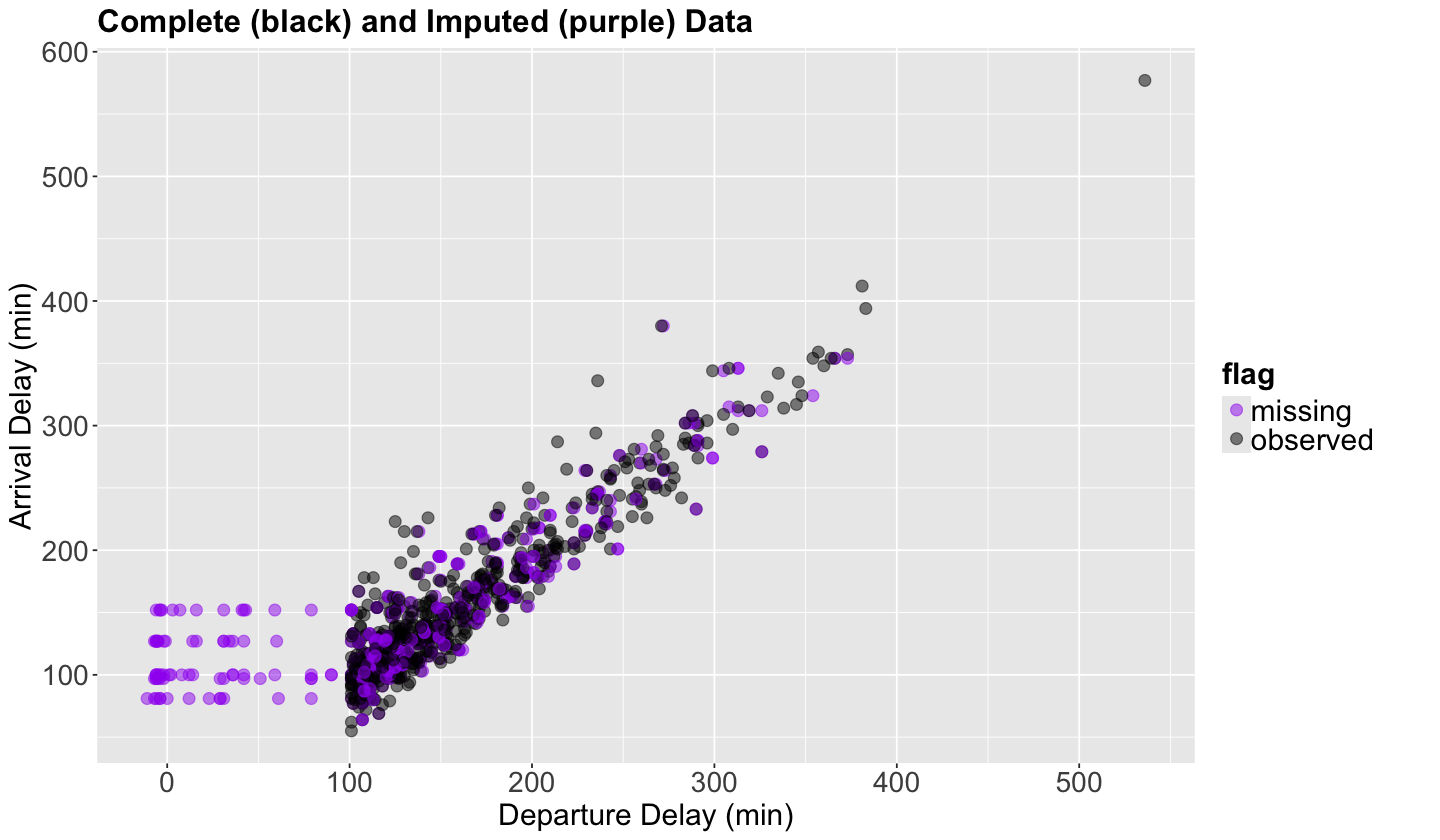

In [27]:
sampled_flights_imputed_PMM_3_plot

```{attention}
Note this imputation method allows incomplete observations to be imputed with more realistic values, rather than just an overall mean or a fitted value coming from simple OLS regression (**check purple points on top of the cloud of black points on the right-hand side**). Nevertheless, it is not entirely perfect if it does not have enough complete information to impute (**check purple points on the left-hand side where we do not have any complete data points in black**).
```

Now, let us estimate an OLS linear regression for each one of the 20 imputed datasets in `sampled_flights_imputed_PMM`. **Our response will be `arr_delay` subject `dep_delay`**.

In [28]:
PMM_LR_models <- with(sampled_flights_imputed_PMM, lm(arr_delay ~ dep_delay))
print(PMM_LR_models)

call :
with.mids(data = sampled_flights_imputed_PMM, expr = lm(arr_delay ~ 
    dep_delay))

call1 :
mice(data = sampled_flights, m = 20, printFlag = FALSE)

nmis :
dep_delay arr_delay 
      354       407 

analyses :
[[1]]

Call:
lm(formula = arr_delay ~ dep_delay)

Coefficients:
(Intercept)    dep_delay  
    30.6428       0.8202  


[[2]]

Call:
lm(formula = arr_delay ~ dep_delay)

Coefficients:
(Intercept)    dep_delay  
    21.8563       0.8677  


[[3]]

Call:
lm(formula = arr_delay ~ dep_delay)

Coefficients:
(Intercept)    dep_delay  
    35.0526       0.8003  


[[4]]

Call:
lm(formula = arr_delay ~ dep_delay)

Coefficients:
(Intercept)    dep_delay  
     29.967        0.821  


[[5]]

Call:
lm(formula = arr_delay ~ dep_delay)

Coefficients:
(Intercept)    dep_delay  
    26.5144       0.8451  


[[6]]

Call:
lm(formula = arr_delay ~ dep_delay)

Coefficients:
(Intercept)    dep_delay  
    27.2239       0.8385  


[[7]]

Call:
lm(formula = arr_delay ~ dep_delay)

Coefficient

We can access to each model separately as follows:

In [29]:
# Retrieving the third model.
PMM_LR_models$analyses[[3]]


Call:
lm(formula = arr_delay ~ dep_delay)

Coefficients:
(Intercept)    dep_delay  
    35.0526       0.8003  


Finally, let us combine the models altogether in a **single pooled model**.

In [30]:
pooled_PMM_LR_model <- pool(PMM_LR_models)
print(pooled_PMM_LR_model)

Class: mipo    m = 20 
         term  m  estimate         ubar            b            t dfcom
1 (Intercept) 20 28.262276 5.2134906153 1.668369e+01 22.731369026   998
2   dep_delay 20  0.833603 0.0001842278 5.009364e-04  0.000710211   998
        df      riv    lambda       fmi
1 28.06200 3.360105 0.7706478 0.7854151
2 30.54513 2.855070 0.7406014 0.7560670


The `estimate` column is just the averages of all `m` models. **Full details about the computation on these columns are provided by [Rubin (1987)](https://gw2jh3xr2c.search.serialssolutions.com/log?L=GW2JH3XR2C&D=ZEEST&J=TC0000340639&P=Link&PT=EZProxy&H=6c88ebd0c3&U=https%3A%2F%2Fezproxy.library.ubc.ca%2Flogin%3Furl%3Dhttps%3A%2F%2Fonlinelibrary.wiley.com%2Fdoi%2Fbook%2F10.1002%2F9780470316696) on pages 76 and 77.** The columns are explained as follows:

- `estimate`: the average of the regression coefficients across `m` models.
- `ubar`: the average variance (i.e., average `SE`^2) across `m` models.
- `b`: the sample variance of the `m` regression coefficients.
- `t`: a final estimate of the `SE`^2 of each regression coefficient. 
	- = `ubar + (1 + 1/m) * b`

- `dfcom`: the degrees of freedom associated with the final regression coefficient estimates.
	- An `alpha`-level confidence interval: `estimate +/- qt(alpha/2, df) * sqrt(t)`.
- `riv`: the relative increase in variance due to randomness. 
	- = `t/ubar - 1`
- `lambda`: the proportion of total variance due to missingness.
- `fmi`: the fraction of missing information.

**Where are the usual outputs (`std.error`, `p.value`,...)?**

We can call `summary()` on the pooled model to obtain them. **The usual coefficient interpretations and inferential rules also apply in this pooled OLS model**.

In [31]:
summary(pooled_PMM_LR_model)

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),28.262276,4.76774255,5.927811,28.06200,2.203849e-06
dep_delay,0.833603,0.02664978,31.279914,30.54513,9.205948e-25


## 3. Wrapping Up

- Data imputation involves some wrangling effort and proper missingness visualizations.
- We have to be careful when defining our class of data missingness since this will determine the type of data imputation we need to make (or maybe data deletion!).
- In general, **multiple imputation will work OK for MAR and MNAR data.**
- We only saw continuous imputation in this example. Nonetheless, the `mice()` approach can be extended to other data types such as binary or categorical. In those cases, we have to switch to generalized linear models (GLMs), **even with a Bayesian approach such as multiple imputation**.